In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "sisi"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from Utils.data_utils import load_train_test_data
from matplotlib import pyplot as plt
from pandas import Timestamp
import time
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [6]:
np.random.seed(2137)

In [31]:
(train_list, test_list), state_list = load_train_test_data(pwd)

In [61]:
train_list[0].shape

(30620, 1)

In [41]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [52]:
trainX, trainY = create_dataset(train_list[0].values, look_back=24)
testX, testY = create_dataset(test_list[0].values, look_back=24)

In [54]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [55]:
trainX.shape

(30595, 1, 24)

In [56]:
trainX.shape

(30595, 1, 24)

# Utils

In [82]:
def fit_model(create_model, X_train, Y_train, look_back=24, batch_size=1000, n_epochs=100, lr_start=0.001, lr_patience=None):
    model = create_model(look_back, lr_start)
    
    callbacks = []
    if lr_patience is not None:
        callbacks.append(k_callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
        
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, callbacks=callbacks).history
    
    return history, model

def plot_history(history, title, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"loss ({history[f'loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.suptitle(title)
    plt.show()

In [83]:
def create_model_v1(look_back=24, lr=0.001):
    model = Sequential()
    model.add(LSTM(1000, input_shape=(1,look_back)))
    model.add(Dense(500))
    model.add(Dense(100))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
        
    return model

In [85]:
history, model = fit_model(create_model_v1, trainX, trainY)

Epoch 1/100


2022-05-31 22:08:21.835695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 22:08:21.950075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/31 [..............................] - ETA: 27s - loss: 150721.0000

2022-05-31 22:08:22.093034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 26ms/step - loss: 39731.9648
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 6490.9761
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 5708.5303
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 4898.1597
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 4122.9160
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 3706.4985
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 3349.0461
Epoch 8/100
31/31 [==============================] - 1s 22ms/step - loss: 3265.9675
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 3062.8362
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 2987.1602
Epoch 11/100
31/31 [==============================] - 1s 21ms/step - loss: 2818.9692
Epoch 12/100
31/31 [==============================] - 1s 20ms/step - loss: 2728.2542


31/31 [==============================] - 1s 20ms/step - loss: 2968.5503
Epoch 98/100
31/31 [==============================] - 1s 21ms/step - loss: 3172.4106
Epoch 99/100
31/31 [==============================] - 1s 20ms/step - loss: 3173.8003
Epoch 100/100
31/31 [==============================] - 1s 20ms/step - loss: 2987.5288


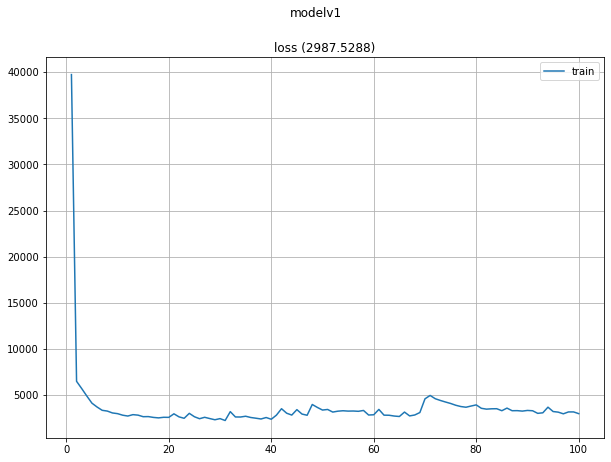

In [87]:
plot_history(history, title='modelv1')

In [76]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2022-05-31 21:42:01.217030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 21:42:01.256946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [77]:
trainPredict.reshape(-1).shape

(30595,)

In [78]:
train_list[0].shape

(30620, 1)

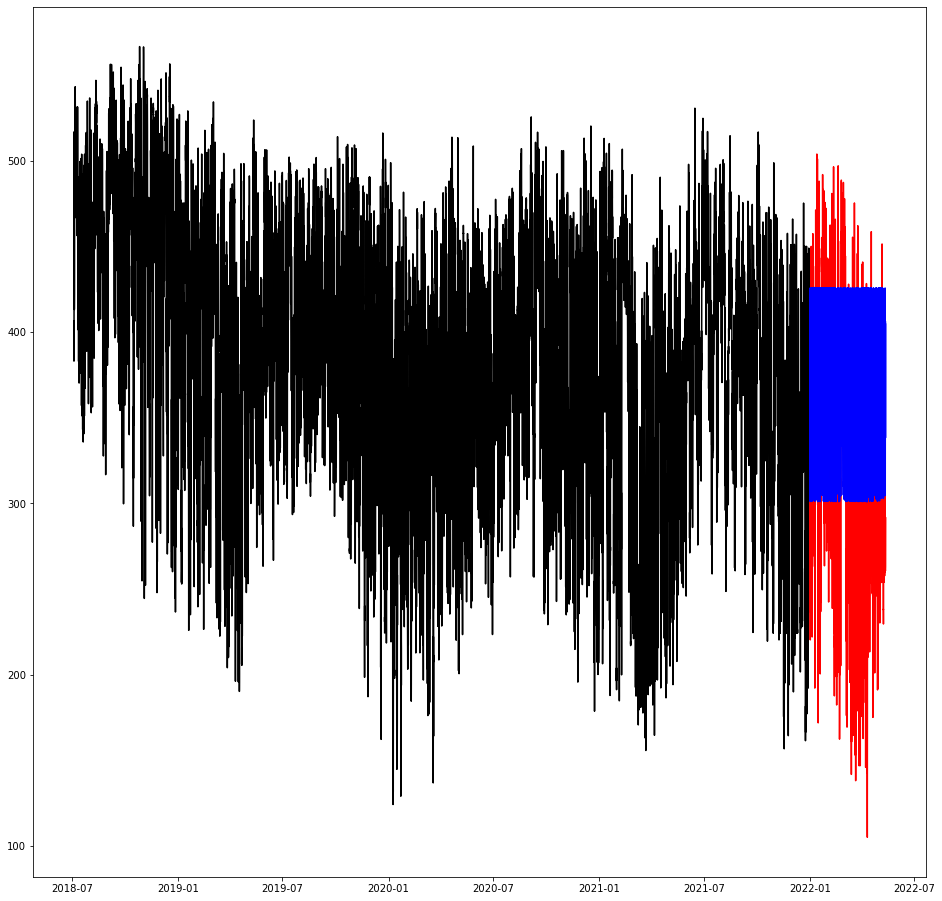

In [79]:
plt.figure(figsize=(16,16))
plt.plot(train_list[0].index[25:], train_list[0]['carbon_per_MWh'][25:], color='black')
plt.plot(test_list[0].index[25:], test_list[0]['carbon_per_MWh'][25:], color='red')
plt.plot(test_list[0].index[25:], testPredict, color='blue')